# ABR analysis

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from usnm2p.fileops import get_data_root, save_figs_book
from usnm2p.logger import logger
from usnm2p.postpro import free_expand
from usnm2p.abr_utils import *
from usnm2p.constants import *
from usnm2p.plotters import harmonize_axes_limits

figs = {}

### Input/output directories

In [3]:
dataroot = get_data_root(kind='ABR')
figsroot = get_data_root(kind=DataRoot.FIG)

### Parameters

In [10]:
ABR_tbounds = (0.19, 0.26)  # bounds of ABR response window (s)
palette = {'pre': 'C2', 'post': 'C5'}  # colors for pre- and post- data

### Load input data

In [5]:
# List input data files
datadir = os.path.join(dataroot, 'SST130')
ABF_files = [f for f in os.listdir(datadir) if f.endswith('.abf')]
ABF_fpaths = {os.path.splitext(f)[0]: os.path.join(datadir, f) for f in ABF_files}
logger.info(f'found {len(ABF_files)} ABF files in {datadir}')

# Load ABR data
data = pd.concat({k: load_abr_data(v) for k, v in ABF_fpaths.items()}, axis=0, names=['dataset'])

# Select ABR window subset
data = data.loc[data[Label.TIME].between(*ABR_tbounds)]

# Extract sampling rate
dt = data[Label.TIME].iloc[:2].diff().iloc[-1]  # s
sr = np.round(1 / dt)  # Hz
logger.info(f'sampling rate: {sr} Hz')

# Extract information from 'dataset' index
logger.info('extracting information from "dataset" index')
datasets = data.index.unique('dataset')
info = parse_ABR_parameters(datasets)

# Add 'info' columns to data index
exp_info = free_expand(info, data)
data = pd.concat([data, exp_info], axis=1)
for k in info.columns:
    logger.info(f'adding {k} information to data index')
    data = data.set_index(k, append=True)
data = data.reorder_levels(['dataset', *info.columns, 'sweep', 'sample'])

# Show data
data

 2024/08/23 11:12:45: found 11 ABF files in /Users/tlemaire/Documents/data/usnm/ABR/SST130
 2024/08/23 11:12:45: loading /Users/tlemaire/Documents/data/usnm/ABR/SST130/20200316_postdeafening_rightear_16kHz_90dB_003.abf ABF file
 2024/08/23 11:12:45: loading /Users/tlemaire/Documents/data/usnm/ABR/SST130/20200304_predeafening_xear_16kHz_xdB_006.abf ABF file
 2024/08/23 11:12:45: loading /Users/tlemaire/Documents/data/usnm/ABR/SST130/20200304_predeafening_xear_16kHz_xdB_004.abf ABF file
 2024/08/23 11:12:45: loading /Users/tlemaire/Documents/data/usnm/ABR/SST130/20200304_predeafening_xear_16kHz_xdB_005.abf ABF file
 2024/08/23 11:12:46: loading /Users/tlemaire/Documents/data/usnm/ABR/SST130/20200304_predeafening_rightear_16kHz_90dB_007.abf ABF file
 2024/08/23 11:12:46: loading /Users/tlemaire/Documents/data/usnm/ABR/SST130/20200316_postdeafening_leftear_8kHz_90dB_006.abf ABF file
 2024/08/23 11:12:46: loading /Users/tlemaire/Documents/data/usnm/ABR/SST130/20200316_postdeafening_leftear_

time (s)  \
dataset                                        date       condition ear   freq (kHz) level (dB) acq sweep sample             
20200316_postdeafening_rightear_16kHz_90dB_003 2020-03-16 post      right 16         90.0       3   0     3800     0.19000   
                                                                                                          3801     0.19005   
                                                                                                          3802     0.19010   
                                                                                                          3803     0.19015   
                                                                                                          3804     0.19020   
...                                                                                                                    ...   
20200304_predeafening_leftear_16kHz_90dB_003   2020-03-04 pre       left  16         90.0       3   511   5196     0.25980   
                                                                                                          5197     0.25985   
                                                                                                          5198     0.25990   
                                                                                                          5199     0.25995   
                                                                                                          5200     0.26000   

                                                                                                                  stim (mV)  \
dataset                                        date       condition ear   freq (kHz) level (dB) acq sweep sample              
20200316_postdeafening_rightear_16kHz_90dB_003 2020-03-16 post      right 16         90.0       3   0     3800    13.122559   
                                                                                                          3801    10.070801   
                                                                                                          3802    10.681152   
                                                                                                          3803     9.155273   
                                                                                                          3804     9.155273   
...                                                                                                                     ...   
20200304_predeafening_leftear_16kHz_90dB_003   2020-03-04 pre       left  16         90.0       3   511   5196    14.038086   
                                                                                                          5197    13.427734   
                                                                                                          5198    13.427734   
                                                                                                          5199    15.869141   
                                                                                                          5200    13.427734   

                                                                                                                   ABR (mV)  
dataset                                        date       condition ear   freq (kHz) level (dB) acq sweep sample             
20200316_postdeafening_rightear_16kHz_90dB_003 2020-03-16 post      right 16         90.0       3   0     3800    14.648438  
                                                                                                          3801    27.160645  
                                                                                                          3802    20.141602  
                                                                                                          3803    10.681152  
                                                                   

### Extract stimulus time bounds from the stimulus channel and align 0 to stimulus onset 

In [6]:
# Extract stimulus ON-OFF indexes from stimulus waveforms
logger.info('extracting stimulus ON-OFF indexes from stimulus waveforms')
stim_ibounds = data['stim (mV)'].groupby('dataset').agg(extract_stim_window)

# Convert to time bounds using reference 'time' vectors
logger.info('converting stimulus ON-OFF indexes to time bounds')
stim_tbounds = pd.Series(
    {k: tuple(data.loc[k, Label.TIME].iloc[np.array(ib)]) for k, ib in stim_ibounds.items()},
    name='stim bounds (s)')

# Offset time vectors to align stimulus onset with t=0
logger.info('offsetting time vectors to align stimulus onset with t=0')
data[Label.TIME] = (
    data[Label.TIME]
    .groupby('dataset')
    .transform(lambda x: x - stim_tbounds[x.index[0][0]][0])
)

# Offset stimulus time bounds as well
logger.info('offsetting stimulus time bounds')
stim_tbounds = pd.Series(
    {k: tuple([0, v[1] - v[0]]) for k, v in stim_tbounds.items()},
    name=stim_tbounds.name)

 2024/08/23 11:13:55: extracting stimulus ON-OFF indexes from stimulus waveforms
 2024/08/23 11:13:58: converting stimulus ON-OFF indexes to time bounds


/var/folders/86/b3z067_j0sbfgbhl7gx4p5640000gn/T/ipykernel_31843/453751699.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  {k: tuple(data.loc[k, Label.TIME].iloc[np.array(ib)]) for k, ib in stim_ibounds.items()},


 2024/08/23 11:13:58: offsetting time vectors to align stimulus onset with t=0
 2024/08/23 11:14:02: offsetting stimulus time bounds


### Plot ABR responses

 2024/08/23 11:17:13: plotting representative stimulus waveform
 2024/08/23 11:17:13: adding inset in the middle of the stimulus waveform
 2024/08/23 11:17:14: plotting ABR waveform for "20200304_predeafening_leftear_16kHz_90dB_003" dataset
 2024/08/23 11:17:16: plotting ABR waveform for "20200304_predeafening_rightear_16kHz_90dB_007" dataset
 2024/08/23 11:17:18: plotting ABR waveform for "20200304_predeafening_xear_16kHz_xdB_004" dataset
 2024/08/23 11:17:20: plotting ABR waveform for "20200304_predeafening_xear_16kHz_xdB_005" dataset
 2024/08/23 11:17:22: plotting ABR waveform for "20200304_predeafening_xear_16kHz_xdB_006" dataset
 2024/08/23 11:17:24: plotting ABR waveform for "20200304_predeafening_xear_16kHz_xdB_008" dataset
 2024/08/23 11:17:25: plotting ABR waveform for "20200304_predeafening_xear_16kHz_xdB_009" dataset
 2024/08/23 11:17:26: plotting ABR waveform for "20200316_postdeafening_leftear_16kHz_90dB_005" dataset
 2024/08/23 11:17:28: plotting ABR waveform for "2020031

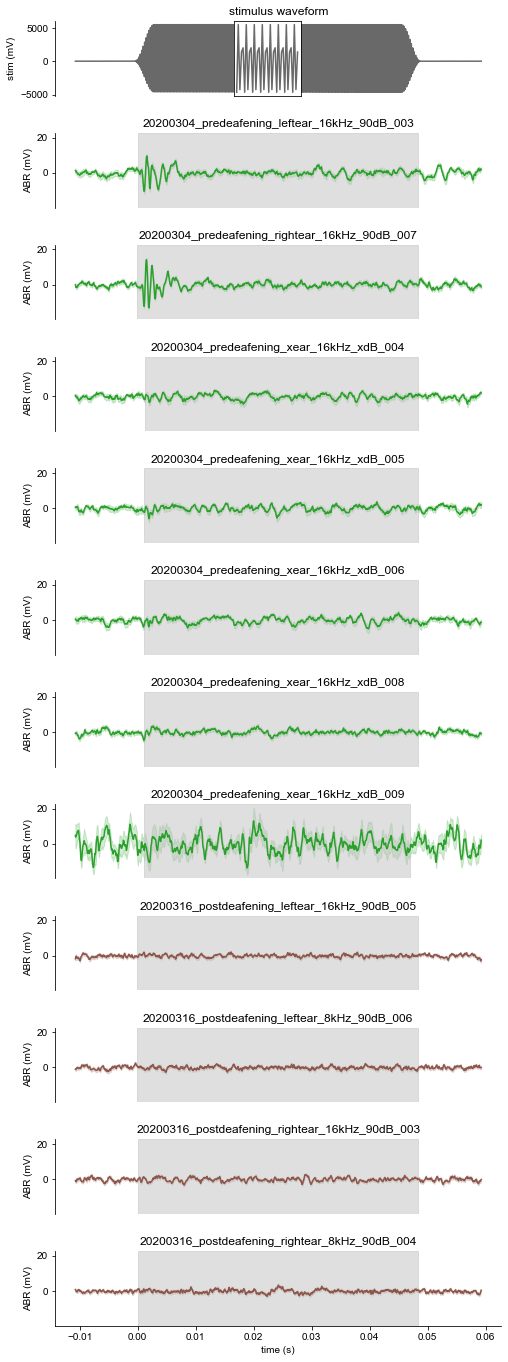

In [16]:
# Create figure
naxes = len(data.index.unique('dataset')) + 1
fig, axes = plt.subplots(naxes, 1, figsize=(8, 2 * naxes))
sns.despine(fig=fig)

# Plot representative stimulus waveform (first available sweep with 8 kHz stim frequency, 
# to avoid showing under-sampled stimulus waveform) on first axis
mux_slice = [slice(None)] * data.index.nlevels
mux_slice[data.index.names.index('freq (kHz)')] = 8
sweepdata = data.loc[tuple(list(data.loc[tuple(mux_slice), :].index[0][:-1]) + [slice(None)])]
logger.info('plotting representative stimulus waveform')
axes[0].set_title('stimulus waveform')
sns.lineplot(
    ax=axes[0], 
    data=sweepdata,
    x=Label.TIME,
    y='stim (mV)',
    c='dimgrey',
)

# Add inset in the middle of the stimulus waveform
logger.info('adding inset in the middle of the stimulus waveform')
inset_tbounds = np.linspace(*stim_tbounds.iloc[0], 100)[[48, 52]]
inset_data = sweepdata[sweepdata[Label.TIME].between(*inset_tbounds)]
inset_ax = axes[0].inset_axes([0.4, 0, 0.15, 1])
inset_ax.set_xticks([])
inset_ax.set_yticks([])
sns.lineplot(
    ax=inset_ax,
    data=inset_data,
    x=Label.TIME,
    y='stim (mV)',
    c='dimgrey',
)

# Plot ABR waveforms on subsequent axes
for ax, (dataset, gdata) in zip(axes[1:], data.groupby('dataset')):
    logger.info(f'plotting ABR waveform for "{dataset}" dataset')
    ax.set_title(dataset)
    sns.lineplot(
        ax=ax,
        data=gdata,
        x=Label.TIME,
        y='ABR (mV)',
        errorbar='se',
        c=palette[gdata.index.unique('condition')[0]],
    )
    ax.axvspan(*stim_tbounds[dataset], color='silver', alpha=0.5)

# Adjust layout
harmonize_axes_limits(axes[1:], 'y')
fig.subplots_adjust(hspace=0.5)
for ax in axes[:-1]:
    sns.despine(ax=ax, bottom=True)
    ax.set_xticks([])
    ax.set_xlabel(None)

# Add figure to dictionary
figs['all ABRs'] = fig

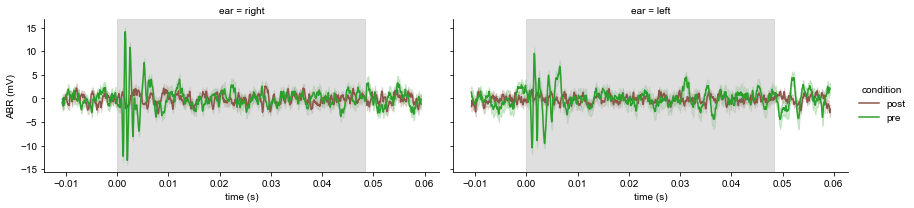

In [17]:
# Select only data at 16 kHz and with clear dB and ear information
fref = 16  # kHz
dBref = 90  # dB
compdata = data.copy()
compdata = compdata.loc[compdata.index.get_level_values('ear') != 'x']
compdata = compdata.loc[compdata.index.get_level_values('freq (kHz)') == fref]
compdata = compdata.loc[compdata.index.get_level_values('level (dB)') == dBref]

# Plot ABR waveforms for each ear, frequency and condition
g = sns.relplot(
    kind='line',
    data=compdata,
    x=Label.TIME,
    y='ABR (mV)',
    col='ear',
    hue='condition',
    palette=palette,
    errorbar='se',
    aspect=2,
    height=3,
)
for ax in g.axes.flat:
    ax.axvspan(*stim_tbounds[compdata.index.unique('dataset')[0]], color='silver', alpha=0.5)

# Add figure to dictionary
figs['direct comp ABRs'] = g.fig

### Save figure(s) and log completion

In [18]:
save_figs_book(figsroot, figs, suffix='ABRs')
logger.info('done')

 2024/08/23 11:18:07: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2024.08.23/figs_ABRs.pdf:


100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


 2024/08/23 11:18:07: done
